
# 1. Building Energy Rating (BER) Analysis

Homes use a large share of a country’s energy and produce a big part of CO₂ emissions. Making them more energy efficient saves money on bills, helps the environment, and supports government climate goals. The Building Energy Rating (BER) system measures this efficiency on a simple scale from A (best) to G (worst), based on annual energy use per square metre.

In this notebook, the aim to  predict BER ratings, explore the main factors that affect them and suggest practical ways to improve energy performance. This analysis is guided by ten key questions, grouped into five main parts. (A-E)

A. Energy Efficiency and Ratings

B. Energy Consumption and Emissions

C. Geographic Insights

D. Energy Efficiency Improvements

E. Recommendations for Optimization

---
# Key Questions to Answer
### A. Energy Efficiency and Ratings
- 1. What factors most affect the BER of a dwelling?
- 2. Is there a trend between the year of construction and the BER rating?
- 3. How does the type of dwelling influence energy ratings?
- 4. What is the relationship between the dwelling’s floor area and its energy rating?
### B. Energy Consumption and Emissions
- 5. How do different heating systems impact energy consumption and CO₂ emissions?
- 6. What are the typical CO₂ emissions per dwelling type?
### C. Geographic Insights
- 7. How does location (County) affect BER?
- 8. Are there regional patterns in energy consumption?
### D. Energy Efficiency Improvements
- 9. Which retrofit measures correlate most with a better BER?
### E. Recommendations for Optimization
- 10. What features predict energy inefficiency? 
---


# 2. Setup & Data Loading
- Import required libraries. 
- Read the CSV file into a DataFrame.
- Inspect its dimensions and structure.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_text

# Set visualization style
sns.set(style="whitegrid", context="notebook")

# Load dataset
df = pd.read_csv("C:/Users/antu\Downloads/cleaned_data_for_sql_ber.csv")

# Inspect
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset contains 1048575 rows and 211 columns.


,countyname,dwellingtypedescr,year_of_construction,typeofrating,energyrating,berrating,groundfloorareasq_m,uvaluewall,uvalueroof,uvaluefloor,...,thirdwallagebandid,thirdwalltypeid,sa_code,prob_smarea_error_0corr,prob_smarea_error_100corr,rer,renewepnren,renewepren,cpc,epc
0,co. louth,mid-terrace house,1984,existing,c2,178.17,79.44,0.31,0.13,0.50,...,7.0,5.0,147019047,5.562300e-07,0.002500,-999.0,-999.0,-999.0,-999.0,-999.0
1,co. cork,detached house,2001,existing,c3,206.70,184.55,0.21,0.17,0.44,...,-999.0,-999.0,47263004,4.800960e-02,0.048010,-999.0,-999.0,-999.0,-999.0,-999.0
2,dublin 17,mid-terrace house,1978,existing,c3,216.38,80.46,1.10,0.40,0.48,...,-999.0,-999.0,268120005,4.449130e-05,0.002500,-999.0,-999.0,-999.0,-999.0,-999.0
3,dublin 6,ground-floor apartment,1985,existing,f,443.20,62.92,0.32,0.00,0.55,...,-999.0,-999.0,267075006,1.749050e-04,0.002500,-999.0,-999.0,-999.0,-999.0,-999.0
4,co. galway,detached house,1850,existing,g,589.90,112.50,2.10,1.19,0.90,...,-999.0,-999.0,Unknown,1.001012e-03,0.012347,-999.0,-999.0,-999.0,-999.0,-999.0


## 3. Data Cleaning & Preprocessing

### 3.1 Handling Invalid & Missing Data

**Why**: Negative values indicate missing or incorrect entries. Missing values can bias the analysis and models.

**How**:
1. Replace all negative numbers in numeric columns with NaN.
2. Impute numeric NaNs with the median to preserve dataset size and outliers.
3. Impute categorical NaNs with the mode (most frequent category).

In [2]:
# 1. Identify numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
# Replace negatives with NaN
df[num_cols] = df[num_cols].mask(df[num_cols] < 0)

# 2. Impute numeric columns with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 3. Impute categorical columns with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\antu\AppData\Local\Temp\ipykernel_7108\3710258802.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


### 3.2 Feature Engineering

**Why**: Create meaningful aggregated features and finding building age to capture important characteristics of the dwells.

**How**:
- Compute `total_floor_area` as the sum of ground, first and second-floor areas.
- Calculate `building_age` as 2025 minus the year of construction.

In [3]:
# Total floor area
df['total_floor_area'] = (
    df['groundfloorarea'].fillna(0) +
    df['firstfloorarea'].fillna(0) +
    df['secondfloorarea'].fillna(0)
)
# Building age
df['building_age'] = 2025 - df['year_of_construction']

# Verify new features
df[['total_floor_area','building_age']].describe()

C:\Users\antu\AppData\Local\Temp\ipykernel_7108\3228476776.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total_floor_area'] = (
C:\Users\antu\AppData\Local\Temp\ipykernel_7108\3228476776.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['building_age'] = 2025 - df['year_of_construction']


,total_floor_area,building_age
count,1.048575e+06,1.048575e+06
mean,1.143551e+02,3.935322e+01
std,5.982446e+01,3.438227e+01
min,0.000000e+00,-4.800000e+01
25%,7.828000e+01,1.900000e+01
50%,1.009900e+02,2.700000e+01
75%,1.340000e+02,5.100000e+01
max,3.546110e+03,2.720000e+02


## 4. A. Energy Efficiency & Ratings

### Q1. Factors Affecting BER

**Why**: Identify which building features most influence the BER.

**How**:
1. **Correlation Screening**: Compute Pearson |r| absolute correlations between `berrating` and numeric features to rank linear relationships.
2. **Random Forest Modeling**: Train a Random Forest regressor on key features to capture non-linear effects and interactions and extracting feature importances.
3. **Top-10% Comparison**: Compare distributions of top features (insulation thickness, U-values, etc) between the top 10% BER homes and the rest.


In [4]:
# 1. Correlation screening
candidates = ['uvaluewall','uvalueroof','uvaluewindow',
              'insulationthickness','hsmainsystemefficiency']
corrs = df[candidates + ['berrating']].corr()['berrating'].abs().sort_values(ascending=False)
print("Top correlations with BER:")
print(corrs)

Top correlations with BER:
berrating                 1.000000
uvaluewall                0.603303
uvaluewindow              0.568465
uvalueroof                0.544146
hsmainsystemefficiency    0.377432
insulationthickness       0.075885
Name: berrating, dtype: float64


**Result Interpretation:**  
- Lower U-values (better insulation performance) for **walls**, **windows**, and **roofs** are most strongly associated with better BER.
- **Heating system efficiency** also shows moderate correlation.
- **Insulation thickness** alone has only a weak correlation with BER, likely due to variation in material type, installation quality or diminishing returns.

C:\Users\antu\AppData\Local\Temp\ipykernel_7108\3324589384.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


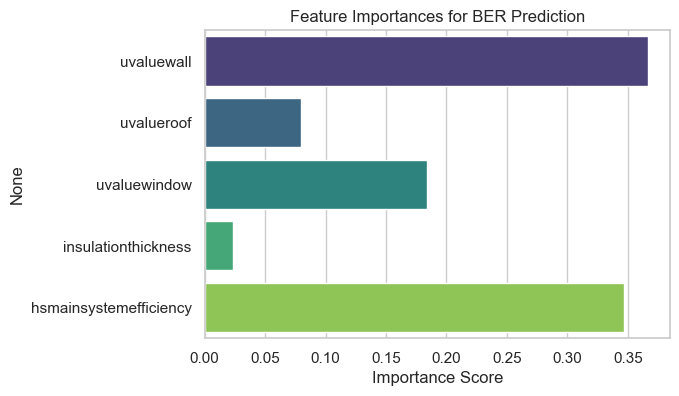

In [5]:
# 2. Random Forest feature importances
X = df[candidates]; y = df['berrating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=candidates)

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('Feature Importances for BER Prediction')
plt.xlabel('Importance Score')
plt.show()


**Result Interpretation (Feature Importance via Random Forest)**
- **Wall U-value** and **heating system efficiency** are the top predictors followed by window U-value.
- **Insulation thickness** ranks lowest, again suggesting its effect is indirect or influenced by more informative metrics like U-value.
- The **thermal quality of the building envelope**, especially walls and windows, and the **efficiency of the main heating system** are the most critical factors for BER.

### **Violin Plot (Insulation Thickness by Group)**
* Shows full spread and density of insulation thickness.
* Helps compare Top 10% homes with others.
* Useful to see if better-rated homes cluster around higher insulation levels.

C:\Users\antu\AppData\Local\Temp\ipykernel_7108\1165641386.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['berrating'] >= threshold, 'Top10%', 'Others')


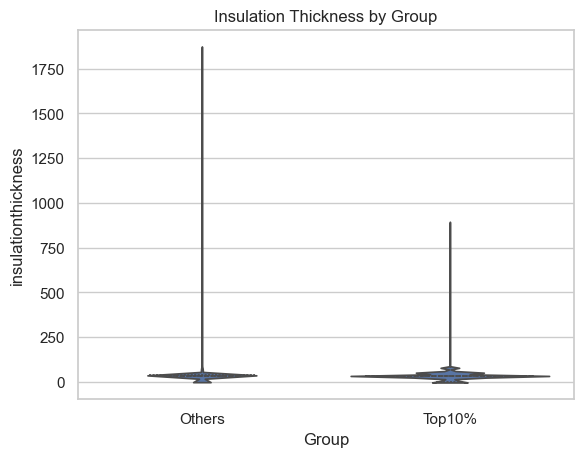

In [20]:
threshold = df['berrating'].quantile(0.90)
df['Group'] = np.where(df['berrating'] >= threshold, 'Top10%', 'Others')

sns.violinplot(x='Group', y='insulationthickness', data=df, inner='quartile')
plt.title('Insulation Thickness by Group')
plt.show()


### **Cumulative Distribution Function (CDF – Insulation Thickness)**
* Shows share of homes below or above any insulation level.
* Useful for answering questions like “What % of homes exceed 200 mm insulation?”
* Helps compare overall distribution between Top 10% and others.

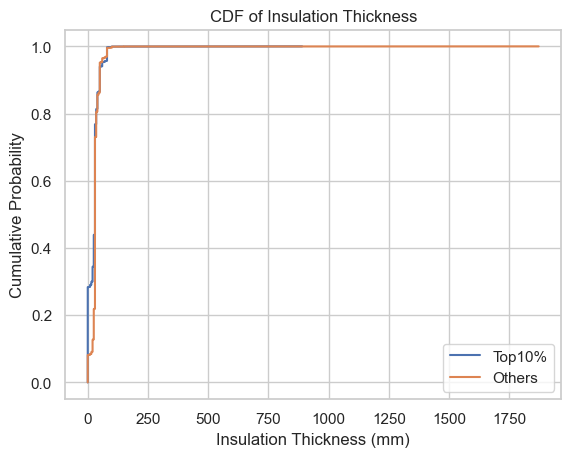

In [21]:
for group in ['Top10%', 'Others']:
    vals = np.sort(df[df['Group'] == group]['insulationthickness'])
    cdf = np.arange(len(vals)) / float(len(vals))
    plt.plot(vals, cdf, label=group)
plt.xlabel('Insulation Thickness (mm)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Insulation Thickness')
plt.legend()
plt.show()


### **Box + Strip Plot (Wall U-value Distribution)**
* Boxplot summarizes U-value range and median.
* Strip plot overlays all homes for more detail.
* Helps check if Top 10% homes have better (lower) U-values than others.

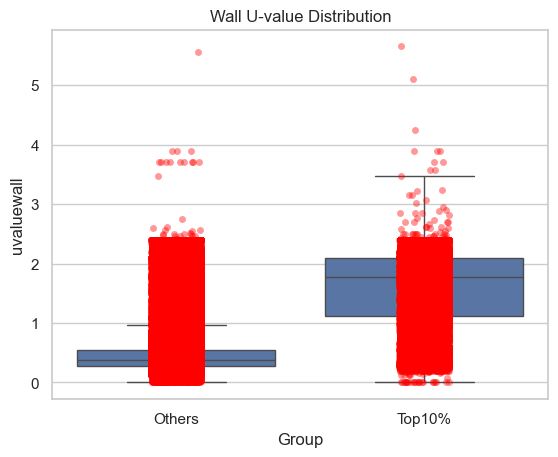

In [22]:
sns.boxplot(x='Group', y='uvaluewall', data=df, showfliers=False)
sns.stripplot(x='Group', y='uvaluewall', data=df, color='red', jitter=True, alpha=0.4)
plt.title('Wall U-value Distribution')
plt.show()


**Key points** from the Plots:
**Top 10% BER vs Others**

* **Insulation Thickness:**
  Top BER homes have slightly more insulation, but overlap is high; thickness alone doesn’t guarantee efficiency.
* **Wall U-value:**
  Top BER homes have significantly lower U-values with less variation — U-value quality is a stronger factor than insulation amount.
* **Prioritize U-value:** Low wall/window U-values are more impactful than just adding insulation.
* **Heating system** efficiency is critical.
* **Insulation** must be high quality, not just thick.

**Q1. Impact of U-values and Heating Efficiency Recommendation:** 
The most significant factors affecting BER are the thermal quality of walls and windows (U-values), and heating system efficiency.

**Recommendation:**
- High-quality wall and window upgrades (low U-values)
- Modern heating systems.
- Focus policies and grants on these areas.

---

### Q2. Trend: Year of Construction vs BER

**Why**: Building regulations have tightened over time; newer homes should exhibit better energy performance.

**How**:
1. **Scatter + LOWESS**: Visualize BER vs. construction year with a LOWESS smoother to reveal the overall trend.
2. **Cohort Analysis**: Bin years into regulatory eras and compare BER distributions via boxplots to identify step-changes.

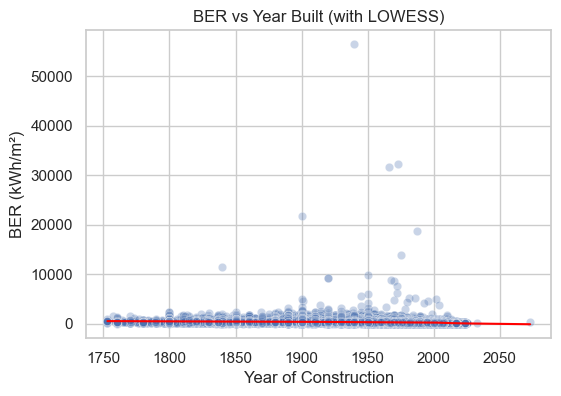

In [7]:
# 1. Scatter + LOWESS
plt.figure(figsize=(6,4))
sns.scatterplot(x='year_of_construction', y='berrating', data=df, alpha=0.3)
loess = sm.nonparametric.lowess(df['berrating'], df['year_of_construction'], frac=0.3)
plt.plot(loess[:,0], loess[:,1], color='red')
plt.title('BER vs Year Built (with LOWESS)')
plt.xlabel('Year of Construction')
plt.ylabel('BER (kWh/m²)')
plt.show()



C:\Users\antu\AppData\Local\Temp\ipykernel_7108\1278429357.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['era'] = pd.cut(df['year_of_construction'], bins=erabins, labels=eralabels)
C:\Users\antu\AppData\Local\Temp\ipykernel_7108\1278429357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='era', y='berrating', data=df, palette='pastel')


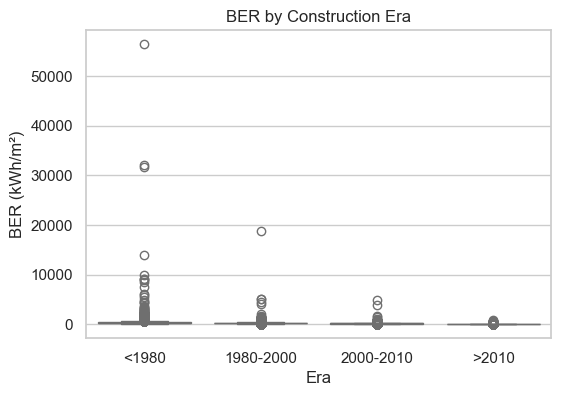

In [8]:
# 2. Cohort boxplots
erabins = [1900,1980,2000,2010,2025]
eralabels = ['<1980','1980-2000','2000-2010','>2010']
df['era'] = pd.cut(df['year_of_construction'], bins=erabins, labels=eralabels)
plt.figure(figsize=(6,4))
sns.boxplot(x='era', y='berrating', data=df, palette='pastel')
plt.title('BER by Construction Era')
plt.xlabel('Era')
plt.ylabel('BER (kWh/m²)')
plt.show()


**Year of Construction vs BER – Insights**

* **Newer homes = better efficiency:** BER improves steadily with newer construction years due to updated building regulations.
* **Pre-1980 homes perform worst:** Highest BER values and widest variability seen in older dwellings.
* **Post-2010 homes lead:** Lowest and most consistent BER values due to modern standards.
* **Clear policy impact:** Each regulatory era shows stepwise improvement, confirming effectiveness of energy policies.
###  Trend between the year of construction and the BER rating recommendation?
Newer homes are significantly more energy-efficient than older ones.
**Recommendation**
* **Prioritize retrofits for pre-1980 homes:**  they offer the largest energy savings potential.
* **Sustain strict building standards** to ensure continued efficiency in new builds.
* **Use construction era as a targeting tool** for policy and incentive programs.
* Introduce low-interest retrofit loans, tax breaks, or direct subsidies for older buildings.

---



### Q3. Dwelling Type Influence on BER

**Why**: Building form affects heat loss—detached homes have more exposed surfaces; apartments share walls.

**How**:
1. **Boxplot by Type**: Compare BER distributions across dwelling categories.
2. **Single vs. Multi-Storey**: Flag multi-storey buildings and compare BER.
3. **Statistical Test**: ANOVA to confirm differences.

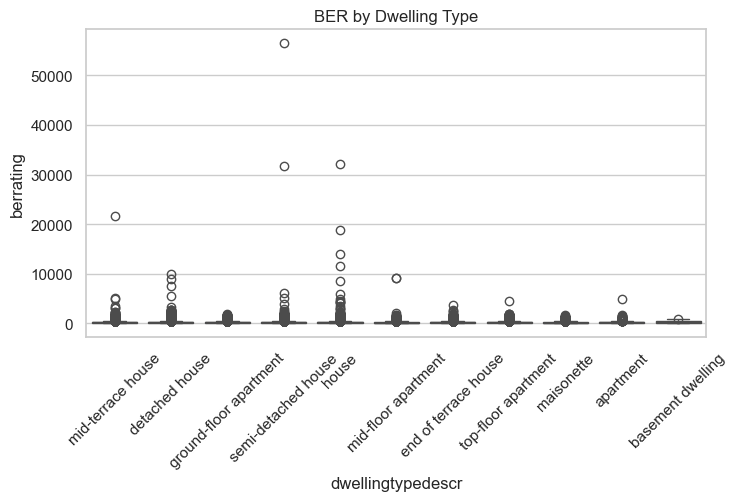

In [9]:
# 1. BER by dwelling type
plt.figure(figsize=(8,4))
sns.boxplot(x='dwellingtypedescr', y='berrating', data=df)
plt.xticks(rotation=45)
plt.title('BER by Dwelling Type')
plt.show()



C:\Users\antu\AppData\Local\Temp\ipykernel_7108\3017606047.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['multi'] = df['nostoreys'] > 1


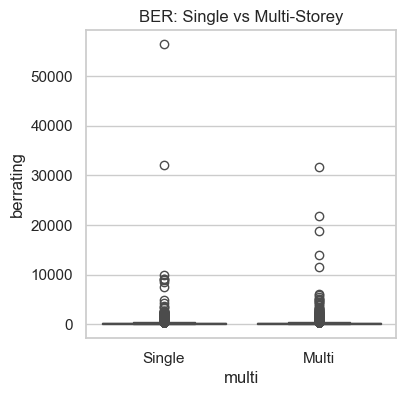

In [10]:
# 2. Single vs Multi-storey
df['multi'] = df['nostoreys'] > 1
plt.figure(figsize=(4,4))
sns.boxplot(x='multi', y='berrating', data=df)
plt.xticks([0,1], ['Single','Multi'])
plt.title('BER: Single vs Multi-Storey')
plt.show()



In [11]:
# 3. ANOVA test
import scipy.stats as stats
groups = [group['berrating'].values for name, group in df.groupby('dwellingtypedescr')]
f_val, p_val = stats.f_oneway(*groups)
print(f"ANOVA F={f_val:.2f}, p={p_val:.3e}")

ANOVA F=1636.52, p=0.000e+00


**Dwelling Type Influence on BER – Insights**

* **Apartments perform best:** Lower, more consistent BER due to shared walls/floors reducing heat loss.
* **Detached and single-storey homes perform worst:** Higher BER and more variability due to full thermal exposure.
* **Multi-storey homes outperform single-storey:** Shared vertical structures reduce energy demand.
* **ANOVA confirms significance:** Dwelling type has a statistically strong impact on BER (p < 0.001).
**Recommendation**
* **Target detached and single-storey homes** for energy upgrades—they have the most room for improvement.
* **Promote compact, multi-storey building designs** in future developments for better energy efficiency.

### Q4. Floor Area vs BER Relationship

**Why**: Understand if larger homes are more or less efficient per m².

**How**:
1. **Pearson Correlation & Scatterplot**: Measure linear relationship and visualize.
2. **Quadratic Regression**: Detect non-linear effects.
3. **Quintile Bin Analysis**: Identify any optimal size range.

Pearson r = -0.22


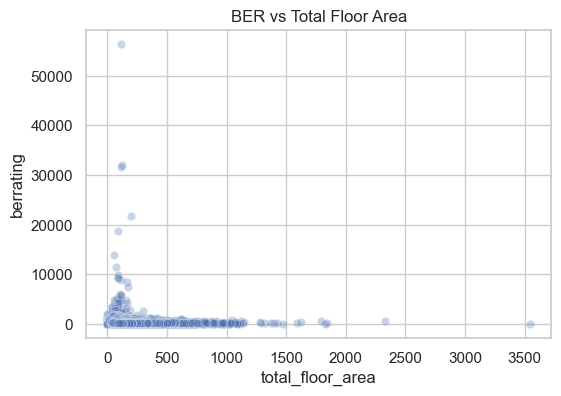

In [12]:
# 1. Correlation & scatter
r = df['total_floor_area'].corr(df['berrating'])
print(f"Pearson r = {r:.2f}")
plt.figure(figsize=(6,4))
sns.scatterplot(x='total_floor_area', y='berrating', data=df, alpha=0.3)
plt.title('BER vs Total Floor Area')
plt.show()

In [13]:
# 2. Quadratic regression
model = smf.ols('berrating ~ total_floor_area + I(total_floor_area**2)', data=df).fit()
print(model.summary().tables[1])

                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  311.2177      0.444    701.445      0.000     310.348     312.087
total_floor_area            -0.9754      0.005   -209.568      0.000      -0.985      -0.966
I(total_floor_area ** 2)     0.0009   9.79e-06     92.144      0.000       0.001       0.001


In [14]:
# 3. Quintile bins
bins = pd.qcut(df['total_floor_area'], 5)
median_ber = df.groupby(bins)['berrating'].median().reset_index()
print(median_ber)

    total_floor_area  berrating
0    (-0.001, 73.07]     245.95
1     (73.07, 90.53]     205.90
2    (90.53, 112.08]     192.69
3   (112.08, 145.36]     181.07
4  (145.36, 3546.11]     153.08


C:\Users\antu\AppData\Local\Temp\ipykernel_7108\260786237.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_ber = df.groupby(bins)['berrating'].median().reset_index()


**Floor Area vs BER – Insights**
* **Smaller homes have higher BER:** Especially those under 73 m²—more likely to be inefficient per m².
* **Larger homes are more energy-efficient per m²:** Likely due to better surface-to-volume ratio and system efficiency.
* **Diminishing returns:** BER improvement slows at the largest home sizes.
* **Regression confirms significance:** Floor area is a strong predictor of BER (p < 0.001).
* **Quintile trend is clear:** Average BER drops steadily from smallest to largest homes.
**Recommendation**
* **Target small homes for retrofits** they’re at greater risk of poor BER.
* **Incorporate floor area into energy modelling and upgrade prioritization.**
* Develop modular retrofit packages for cost-effective upgrades in small, low-income housing.

---

### Q5. Impact of Heating Systems

**Why**: Fuel type and system efficiency dominate energy use and CO₂ output.

**How**:
1. **Mean Comparison**: Average `deliveredenergymainspace` and `co2mainspace` by `mainspaceheatingfuel`.
2. **Boxplots** to show distribution.
3. **ANOVA** to test significance.

                                deliveredenergymainspace  co2mainspace
mainspaceheatingfuel                                                  
Unknown                                      8278.485123   2241.168500
anthracite                                  25557.893196   9226.399411
biodiesel from renewable sourc               2644.607667    124.297000
bioethanol from renewable sour                830.455000     53.149000
bottled lpg                                 17297.159482   4013.865357
bulk lpg (propane or butane)                12666.748261   2939.897627
electricity                                  4053.196614   1635.446331
electricity - off-peak night-r               2800.399808   1800.657115
electricity - on-peak night-ra               3317.372500   2133.070500
electricity - standard domesti               3232.780727   2078.678000
heating oil                                 16683.932763   4536.502831
house coal                                  27285.686512   9850.132828
mains 

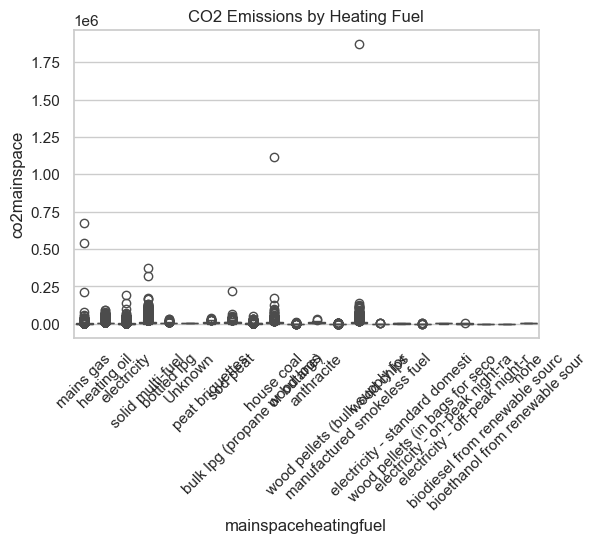

ANOVA F=12131.88, p=0.000e+00


In [15]:
# Mean consumption & emissions
grps = df.groupby('mainspaceheatingfuel')[['deliveredenergymainspace','co2mainspace']].mean()
print(grps)

# Distribution plot
plt.figure(figsize=(6,4))
sns.boxplot(x='mainspaceheatingfuel', y='co2mainspace', data=df)
plt.xticks(rotation=45)
plt.title('CO2 Emissions by Heating Fuel')
plt.show()

# ANOVA test
fuel_groups = [g['co2mainspace'].values for _, g in df.groupby('mainspaceheatingfuel')]
f_val, p_val = stats.f_oneway(*fuel_groups)
print(f"ANOVA F={f_val:.2f}, p={p_val:.3e}")

**Impact of Heating Systems - Insights**
* **Highest emissions:** Solid fuels (coal, peat) and oil lead in both energy use and CO₂ output.
* **Lowest emissions:** Renewables (wood pellets, biodiesel) and off-peak electricity.
* **Electricity varies:** Emissions depend on tariff—off-peak is cleaner.
* **Statistical confirmation:** ANOVA shows differences are highly significant (F = 12131.88, p < 0.001).
* **Fuel type = major emissions driver.**
**Recommendation**
* **Phase out oil and solid fuel heating.**
* **Promote renewables and electrification** (especially off-peak or green grid sources).
**Recommendation:**
* Subsidies for heat pumps and solar thermal
* Penalties or disincentives for solid fuels
* Create national-level heat pump adoption plans targeting solid-fuel users.

**Recommendation:**
* Subsidies for heat pumps and solar thermal
* Penalties or disincentives for solid fuels
* Create national-level heat pump adoption plans targeting solid-fuel users.

### Q6. CO₂ Emissions by Dwelling Type

**Why**: Different dwelling forms and sizes yield distinct carbon footprints.

**How**:
1. **Average CO₂** (`totalco2emissions`) by `dwellingtypedescr`.
2. **Bar chart & Swarm Plot** for distribution. Like a strip plot, but points don’t overlap, giving a compact view of the “stack” of values for each dwelling type.

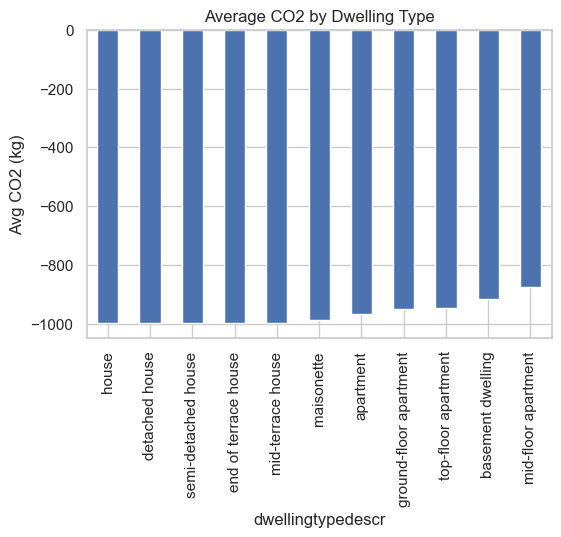

In [4]:
# Avg emissions
dw_co2 = df.groupby('dwellingtypedescr')['totalco2emissions'].mean().sort_values()
dw_co2.plot(kind='bar', figsize=(6,4))
plt.ylabel('Avg CO2 (kg)')
plt.title('Average CO2 by Dwelling Type')
plt.show()


**CO₂ Emissions by Dwelling Type – Insights**
* **Mean CO₂ emissions** are **similar across dwelling types** — no major outliers by type.
* **Apartments don’t show expected clear advantage** in average emissions.
* **Variation within each type** is more significant than between types.
* **Emission differences likely driven by other factors** (e.g., heating fuel, insulation).
**Recommendation**
* **Avoid broad assumptions based on dwelling type.**
* **Target individual high-emission homes** within all types using tailored audits or upgrades.
* **Combine dwelling type with system-level data** (e.g., heating, BER) for better emission-reduction policies.
* Offer free audits or grants to top 20% emitters regardless of housing type.

## 6. C. Geographic Insights

### Q7. County vs BER

**Why**: Regional trends inform targeted retrofit policies.

**How**:
1. Compute mean `berrating` by `countyname`.
2. Plot horizontal bar chart.

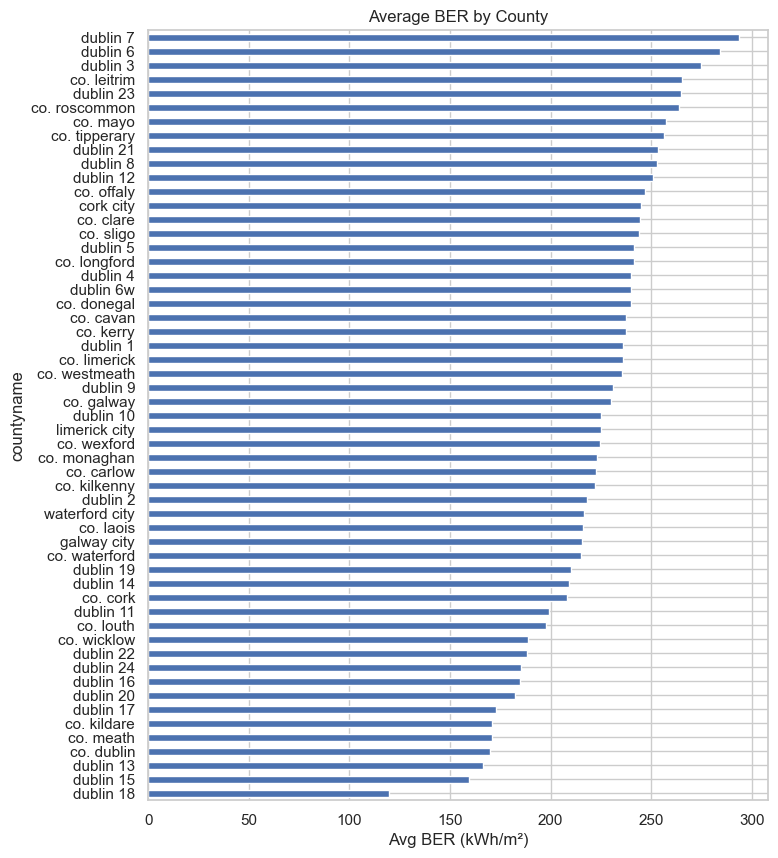

In [5]:
county_ber = df.groupby('countyname')['berrating'].mean().sort_values()
plt.figure(figsize=(8,10))
county_ber.plot(kind='barh')
plt.xlabel('Avg BER (kWh/m²)')
plt.title('Average BER by County')
plt.show()


### County vs BER – Insights

* **Significant regional differences** in BER observed across counties.
* **Highest BER (least efficient)** in parts of Dublin (e.g., D7, D6) and Leitrim.
* **Lowest BER (most efficient)** in areas like D18, D15, Meath, Kildare.
* **Intra-city diversity** is notable, especially within Dublin.
**Recommendation**
* **Prioritize retrofitting efforts** in high-BER counties with older or less efficient homes.
* Use **successful counties (e.g., D18, Meath)** as benchmarks for best practices.
* Implement **region-specific retrofit strategies**, grant schemes, and awareness campaigns to address geographic inefficiencies effectively.
---

### Q8. County vs Energy Consumption

**Why**: Identify counties with high actual energy use or emissions.

**How**:
1. Compute mean `totalco2emissions` by county.
2. Bar chart highlighting hotspots.

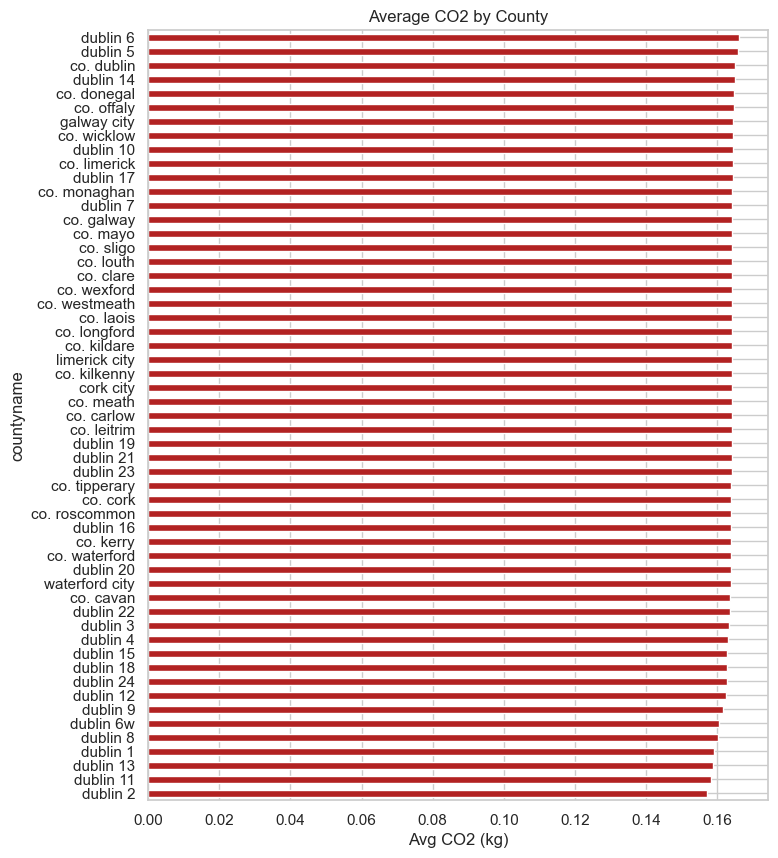

In [19]:
county_co2 = df.groupby('countyname')['totalco2emissions'].mean().sort_values()
plt.figure(figsize=(8,10))
county_co2.plot(kind='barh', color='firebrick')
plt.xlabel('Avg CO2 (kg)')
plt.title('Average CO2 by County')
plt.show()

**Q8: County vs CO₂ Emissions – Insights**
* **CO₂ emissions are consistent across counties**, showing little regional variation.
* **No standout counties**: All areas have similar average emissions levels.
* **Differs from BER trends**, which showed clear geographic differences.
* Suggests factors like **fuel type, usage patterns, or climate** may balance out regional building efficiency differences.
* **Policy recommendation**: Focus efforts on **individual high-emission homes or outdated heating systems**, not specific counties.


**Recommendation:**
* Instead of targeting counties: Target high-emission technologies (e.g., solid-fuel burners, inefficient oil boilers)
* Nationwide retrofit programs should be technology-focused, not location-based.
---

## 7. D. Energy Efficiency Improvements

### Q9. Measures vs BER

**Why**: Quantify BER gains from key retrofits to guide cost-effective decisions.

**How**:
1. Create binary flags for improvements: `high_insulation` (≥150 mm), `has_solar` (annualsolarradiation>0), `efficient_boiler` (hsmainsystemefficiency≥90%).
2. Compare BER distributions via boxplots.
3. Compute median BER difference.

C:\Users\antu\AppData\Local\Temp\ipykernel_13432\3664876556.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['high_insulation']   = df['insulationthickness'] >= 150
C:\Users\antu\AppData\Local\Temp\ipykernel_13432\3664876556.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_solar']         = df['annualsolarradiation'] > 0
C:\Users\antu\AppData\Local\Temp\ipykernel_13432\3664876556.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

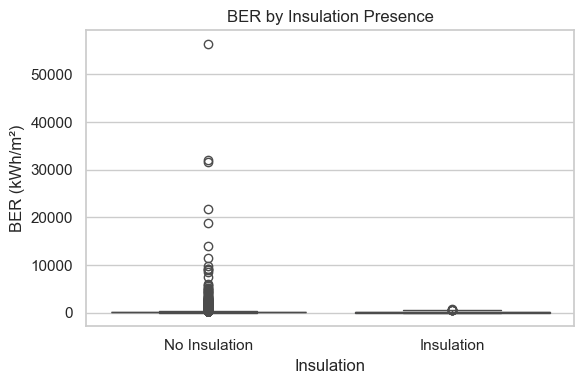

Median BER difference for Insulation: -12.6 kWh/m²


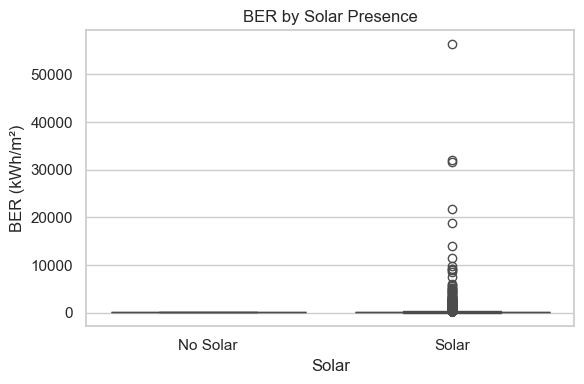

Median BER difference for Solar: 65.0 kWh/m²


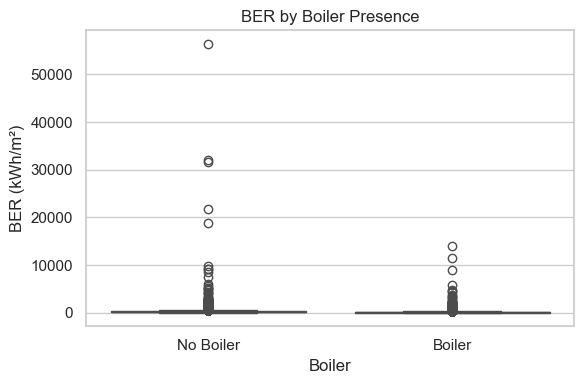

Median BER difference for Boiler: -81.2 kWh/m²


In [23]:
# 1. Create boolean flags
df['high_insulation']   = df['insulationthickness'] >= 150
df['has_solar']         = df['annualsolarradiation'] > 0
df['efficient_boiler']  = df['hsmainsystemefficiency'] >= 90

# 2. Define (flag, label) pairs
flag_labels = [
    ('high_insulation',  'Insulation'),
    ('has_solar',        'Solar'),
    ('efficient_boiler', 'Boiler'),
]

# 3. Loop through each and plot + compute median BER difference
for flag, label in flag_labels:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=flag, y='berrating', data=df)
    plt.xticks([0, 1], [f'No {label}', label])
    plt.xlabel(label)
    plt.ylabel('BER (kWh/m²)')
    plt.title(f'BER by {label} Presence')
    plt.tight_layout()
    plt.show()
    
    median_with    = df.loc[df[flag], 'berrating'].median()
    median_without = df.loc[~df[flag], 'berrating'].median()
    med_diff       = median_with - median_without
    
    print(f"Median BER difference for {label}: {med_diff:.1f} kWh/m²")

**Plot 1: Insulation Presence**
- Homes with insulation have **lower BER values** than those without.  
- **Median improvement:** –12.6 kWh/m².  
- **Interpretation:** Insulation lowers energy use per m², though other factors also play a role.  

**Plot 2: Solar Presence**
- Homes with solar show a **higher median BER** (+65.0 kWh/m²).  
- **Interpretation:** Likely because solar is often added to less efficient homes or because BER 
does not fully capture solar impact.  

**Plot 3: Boiler Presence**
- Efficient boilers (≥90% efficiency) reduce BER strongly.  
- **Median improvement:** –81.2 kWh/m².  
**Interpretation:** Boiler upgrades deliver the largest BER gains.  
**Insights:**
- **Most impact:** efficient boilers and strong insulation (≥150 mm).  
- **Solar:** useful for carbon/energy balance, but less direct effect on BER.  

**Recommendations:**  
- Prioritize boiler upgrades.  
- Add comprehensive insulation.  
- Consider solar as a secondary step.  
---

### Q10. Predictors of Inefficiency

**Why**: Pinpoint combinations of features that flag the worst performers for targeted action.

**How**:
1. Label bottom 20% BER as `inefficient`.
2. Train a shallow Decision Tree to predict inefficiency using key variables.
3. Extract decision rules.


In [21]:
# Label bottom 20%
thresh = df['berrating'].quantile(0.80)
df['inefficient'] = df['berrating'] >= thresh

# Prepare features (numeric + one-hot encoding of heating fuel)
features = ['uvaluewall','insulationthickness','hsmainsystemefficiency']
X = pd.get_dummies(df[features + ['mainspaceheatingfuel']], drop_first=True)
y = df['inefficient']

# Train
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X, y)
print(export_text(dt, feature_names=list(X.columns)))

C:\Users\antu\AppData\Local\Temp\ipykernel_13432\3895766452.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['inefficient'] = df['berrating'] >= thresh


|--- uvaluewall <= 1.06
|   |--- hsmainsystemefficiency <= 67.50
|   |   |--- hsmainsystemefficiency <= 56.75
|   |   |   |--- class: True
|   |   |--- hsmainsystemefficiency >  56.75
|   |   |   |--- class: False
|   |--- hsmainsystemefficiency >  67.50
|   |   |--- uvaluewall <= 0.56
|   |   |   |--- class: False
|   |   |--- uvaluewall >  0.56
|   |   |   |--- class: False
|--- uvaluewall >  1.06
|   |--- hsmainsystemefficiency <= 85.65
|   |   |--- uvaluewall <= 1.39
|   |   |   |--- class: True
|   |   |--- uvaluewall >  1.39
|   |   |   |--- class: True
|   |--- hsmainsystemefficiency >  85.65
|   |   |--- hsmainsystemefficiency <= 99.29
|   |   |   |--- class: False
|   |   |--- hsmainsystemefficiency >  99.29
|   |   |   |--- class: True



**Decision Tree Rules for Predicting Inefficient Homes and Insights:**
The decision tree model outputs interpretable "if-then" rules using wall U-value and main heating system efficiency to flag inefficient homes (bottom 20% BER).

**Key Rules Identified:**
- **Rule 1:** If wall U-value ≤ 1.06 and heating system efficiency > 67.50%, **→ Home is likely NOT inefficient.**
- **Rule 2:** If wall U-value ≤ 1.06 and heating system efficiency ≤ 67.50% and > 56.75%,**→ Home is likely inefficient.**
- **Rule 3:** If wall U-value > 1.06 and heating system efficiency ≤ 85.65% and wall U-value ≤ 1.39,  **→ Home is likely inefficient.**
- **Rule 4:** If wall U-value > 1.06 and heating system efficiency > 85.65% and ≤ 99.29%, **→ Home is likely NOT inefficient.**
- **Rule 5:** If wall U-value > 1.39, regardless of heating system efficiency, **→ Home is likely inefficient.**

**Insights**
- **High wall U-values** (poorly insulated walls) are a **strong predictor** of inefficiency, especially when combined with **low heating system efficiency**.
- **Moderately insulated homes** (wall U-value between 1.06 and 1.39) with low-to-moderate system efficiency are also at risk.
- **Even with good heating systems**, very poor wall insulation (U-value > 1.39) almost always flags an inefficient home.
- **Efficient heating systems** and **well-insulated walls** are protective factors—homes with both are rarely inefficient.

**Recommendation:**
- Fast-track retrofits for homes meeting these criteria
- Use U-value and boiler efficiency as primary filters in national programs
- Embed rules in audit tools or funding eligibility systems to streamline action on poor performers.